# Ibis for SQL Programmers

Ibis provides a full-featured replacement for SQL
`SELECT` queries, but expressed with Python code that is:

-   Type-checked and validated as you go. No more debugging cryptic
    database errors; Ibis catches your mistakes right away.
-   Easier to write. Pythonic function calls with tab completion in
    IPython.
-   More composable. Break complex queries down into easier-to-digest
    pieces
-   Easier to reuse. Mix and match Ibis snippets to create expressions
    tailored for your analysis.

We intend for all `SELECT` queries to be fully portable to Ibis.
Coverage of other DDL statements (e.g. `CREATE TABLE` or `INSERT`) may
vary from engine to engine.

This document will use the Impala SQL compiler (i.e.
`ibis.impala.compile`) for convenience, but the code here is portable to
whichever system you are using Ibis with.

> **Note**: If you find any SQL idioms or use cases in your work that
> are not represented here, please reach out so we can add more to this
> guide!

In [1]:
import ibis

ibis.options.sql.default_limit = None

## Projections: select/add/remove columns

All tables in Ibis are immutable. To select a subset of a table's
columns, or to add new columns, you must produce a new table by means of
a *projection*.

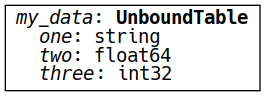

In [2]:
t = ibis.table(
    [('one', 'string'), ('two', 'float'), ('three', 'int32')], 'my_data'
)
t

In SQL, you might write something like:

```sql
SELECT two, one
FROM my_data
```

In Ibis, this is

In [3]:
proj = t['two', 'one']

or

In [4]:
proj = t.projection(['two', 'one'])

This generates the expected SQL:

In [5]:
print(ibis.impala.compile(proj))

SELECT `two`, `one`
FROM my_data


What about adding new columns? To form a valid projection, all column
expressions must be **named**. Let's look at the SQL:

``` sql
SELECT two, one, three * 2 AS new_col
FROM my_data
```

The last expression is written:

In [6]:
new_col = (t.three * 2).name('new_col')

Now, we have:

In [7]:
proj = t['two', 'one', new_col]
print(ibis.impala.compile(proj))

SELECT `two`, `one`, `three` * 2 AS `new_col`
FROM my_data


### `mutate`: Add or modify columns easily

Since adding new columns or modifying existing columns is so common,
there is a convenience method `mutate`:

In [8]:
mutated = t.mutate(new_col=t.three * 2)

Notice that using the `name` was not necessary here because we're using
Python keywords to provide the name. Indeed:

In [9]:
print(ibis.impala.compile(mutated))

SELECT *, `three` * 2 AS `new_col`
FROM my_data


If you modify an existing column with `mutate` it will list out all the
other columns:

In [10]:
mutated = t.mutate(two=t.two * 2)
print(ibis.impala.compile(mutated))

SELECT `one`, `two` * 2 AS `two`, `three`
FROM my_data


### `SELECT *` equivalent

Especially in combination with relational joins, it's convenient to be
able to select all columns in a table using the `SELECT *` construct. To
do this, use the table expression itself in a projection:

In [11]:
proj = t[t]
print(ibis.impala.compile(proj))

SELECT *
FROM my_data


This is how `mutate` is implemented. The example above
`t.mutate(new_col=t.three * 2)` can be written as a normal projection:

In [12]:
proj = t[t, new_col]
print(ibis.impala.compile(proj))

SELECT *, `three` * 2 AS `new_col`
FROM my_data


Let's consider a table we might wish to join with `t`:

In [13]:
t2 = ibis.table([('key', 'string'), ('value', 'float')], 'dim_table')

Now let's take the SQL:

``` sql
SELECT t0.*, t0.two - t1.value AS diff
FROM my_data t0
  INNER JOIN dim_table t1
    ON t0.one = t1.key
```

To write this with Ibis, it is:

In [14]:
diff = (t.two - t2.value).name('diff')
joined = t.join(t2, t.one == t2.key)[t, diff]

And verify the generated SQL:

In [15]:
print(ibis.impala.compile(joined))

SELECT t0.*, t0.`two` - t1.`value` AS `diff`
FROM my_data t0
  INNER JOIN dim_table t1
    ON t0.`one` = t1.`key`


### Using functions in projections

If you pass a function instead of a string or Ibis expression in any
projection context, it will be invoked with the "parent" table as its
argument. This can help significantly when [composing complex operations.
Consider this SQL:

``` sql
SELECT one, avg(abs(the_sum)) AS mad
FROM (
  SELECT one, three, sum(two) AS the_sum
  FROM my_data
  GROUP BY 1, 2
) t0
GROUP BY 1
```

This can be written as one chained expression:

In [16]:
expr = (
    t.group_by(['one', 'three'])
    .aggregate(the_sum=t.two.sum())
    .group_by('one')
    .aggregate(mad=lambda x: x.the_sum.abs().mean())
)

Indeed:

In [17]:
print(ibis.impala.compile(expr))

SELECT `one`, avg(abs(`the_sum`)) AS `mad`
FROM (
  SELECT `one`, `three`, sum(`two`) AS `the_sum`
  FROM my_data
  GROUP BY 1, 2
) t0
GROUP BY 1


## Filtering / `WHERE`

You can add filter clauses to a table expression either by indexing with
`[]` (like pandas) or use the `filter` method:

In [18]:
filtered = t[t.two > 0]
print(ibis.impala.compile(filtered))

SELECT *
FROM my_data
WHERE `two` > 0


`filter` can take a list of expressions, which must all be satisfied for
a row to be included in the result:

In [19]:
filtered = t.filter([t.two > 0, t.one.isin(['A', 'B'])])
print(ibis.impala.compile(filtered))

SELECT *
FROM my_data
WHERE (`two` > 0) AND
      (`one` IN ('A', 'B'))


To compose boolean expressions with `AND` or `OR`, use the respective
`&` and `|` operators:

In [20]:
cond = (t.two < 0) | ((t.two > 0) | t.one.isin(['A', 'B']))
filtered = t[cond]
print(ibis.impala.compile(filtered))

SELECT *
FROM my_data
WHERE (`two` < 0) OR ((`two` > 0) OR `one` IN ('A', 'B'))


## Aggregation / `GROUP BY`

To aggregate a table, you need:

-   Zero or more grouping expressions (these can be column names)
-   One or more aggregation expressions

Let's look at the `aggregate` method on tables:

In [21]:
stats = [t.two.sum().name('total_two'), t.three.mean().name('avg_three')]
agged = t.aggregate(stats)

If you don't use any group expressions, the result will have a single
row with your statistics of interest:

In [22]:
agged.schema()

ibis.Schema {  
  total_two  float64
  avg_three  float64
}

In [23]:
print(ibis.impala.compile(agged))

SELECT sum(`two`) AS `total_two`, avg(`three`) AS `avg_three`
FROM my_data


To add groupings, use either the `by` argument of `aggregate` or use the
`group_by` construct:

In [24]:
agged2 = t.aggregate(stats, by='one')
agged3 = t.group_by('one').aggregate(stats)
print(ibis.impala.compile(agged3))

SELECT `one`, sum(`two`) AS `total_two`, avg(`three`) AS `avg_three`
FROM my_data
GROUP BY 1


### Non-trivial grouping keys

You can use any expression (or function, like in projections) deriving
from the table you are aggregating. The only constraint is that the
expressions must be named. Let's look at an example:

In [25]:
events = ibis.table(
    [('ts', 'timestamp'), ('event_type', 'int32'), ('session_id', 'int64')],
    name='web_events',
)

Suppose we wanted to total up event types by year and month:

In [26]:
keys = [events.ts.year().name('year'), events.ts.month().name('month')]

sessions = events.session_id.nunique()
stats = events.group_by(keys).aggregate(
    total=events.count(), sessions=sessions
)

Now we have:

In [27]:
print(ibis.impala.compile(stats))

SELECT extract(`ts`, 'year') AS `year`, extract(`ts`, 'month') AS `month`,
       count(DISTINCT `session_id`) AS `sessions`, count(*) AS `total`
FROM web_events
GROUP BY 1, 2


### Aggregates considering table subsets

In analytics is it common to compare statistics from different subsets
of a table. Let's consider a dataset containing people's name, age,
gender, and nationality:

In [28]:
pop = ibis.table(
    [
        ('name', 'string'),
        ('country', 'string'),
        ('gender', 'string'),
        ('age', 'int16'),
    ],
    name='population',
)

Now, suppose you wanted to know for each country:

-   Average overall age
-   Average male age
-   Average female age
-   Total number of persons

In SQL, you may write:

``` sql
SELECT country,
       count(*) AS num_persons,
       AVG(age) AS avg_age
       AVG(CASE WHEN gender = 'M'
             THEN age
             ELSE NULL
           END) AS avg_male,
       AVG(CASE WHEN gender = 'F'
             THEN age
             ELSE NULL
           END) AS avg_female,
FROM population
GROUP BY 1
```

Ibis makes this much simpler by giving you `where` option in aggregation
functions:

In [29]:
expr = pop.group_by('country').aggregate(
    num_persons=pop.count(),
    avg_age=pop.age.mean(),
    avg_male=pop.age.mean(where=pop.gender == 'M'),
    avg_female=pop.age.mean(where=pop.gender == 'F'),
)

This indeed generates the correct SQL. Note that SQL engines handle
`NULL` values differently in aggregation functions, but Ibis will write
the SQL expression that is correct for your query engine.

In [30]:
print(ibis.impala.compile(expr))

SELECT `country`, avg(`age`) AS `avg_age`,
       avg(CASE WHEN `gender` = 'F' THEN `age` ELSE NULL END) AS `avg_female`,
       avg(CASE WHEN `gender` = 'M' THEN `age` ELSE NULL END) AS `avg_male`,
       count(*) AS `num_persons`
FROM population
GROUP BY 1


### `count(*)` convenience: `size()`

Computing group frequencies is so common that, like pandas, we have a
method `size` that is a shortcut for the `count(*)` idiom:

In [31]:
freqs = events.group_by(keys).size()
print(ibis.impala.compile(freqs))

SELECT extract(`ts`, 'year') AS `year`, extract(`ts`, 'month') AS `month`,
       count(*) AS `count`
FROM web_events
GROUP BY 1, 2


### Frequency table convenience: `value_counts`

Consider the SQL idiom:

``` sql
SELECT some_column_expression, count(*)
FROM table
GROUP BY 1
```

This is so common that, like pandas, there is a generic array method
`value_counts` which does this for us:

In [32]:
expr = events.ts.year().value_counts()
print(ibis.impala.compile(expr))

SELECT extract(`ts`, 'year') AS `year`, count(*) AS `count`
FROM web_events
GROUP BY 1


### `HAVING` clause

The SQL `HAVING` clause enables you to filter the results of an
aggregation based on some group-wise condition holding true. For
example, suppose we wanted to limit our analysis to groups containing at
least 1000 observations:

``` sql
SELECT one, sum(two) AS total
FROM my_data
GROUP BY 1
HAVING count(*) >= 1000
```

With Ibis, you can do:

In [33]:
expr = (
    t.group_by('one')
    .having(t.count() >= 1000)
    .aggregate(t.two.sum().name('total'))
)
print(ibis.impala.compile(expr))

SELECT `one`, sum(`two`) AS `total`
FROM my_data
GROUP BY 1
HAVING count(*) >= 1000


## Sorting / `ORDER BY`

To sort a table, use the `order_by` method along with either column names
or expressions that indicate the sorting keys:

In [34]:
sorted = events.order_by([events.ts.year(), events.ts.month()])

print(ibis.impala.compile(sorted))

SELECT *
FROM web_events
ORDER BY extract(`ts`, 'year'), extract(`ts`, 'month')


The default for sorting is in ascending order. To reverse the sort
direction of any key, either wrap it in `ibis.desc` or pass a tuple with
`False` as the second value:

In [35]:
sorted = events.order_by(
    [ibis.desc('event_type'), (events.ts.month(), False)]
).limit(100)

print(ibis.impala.compile(sorted))

SELECT *
FROM web_events
ORDER BY `event_type` DESC, extract(`ts`, 'month') DESC
LIMIT 100


## `LIMIT` and `OFFSET`

This one is easy. The table `limit` function truncates a table to the
indicates number of rows. So if you only want the first 1000 rows (which
may not be deterministic depending on the SQL engine), you can do:

In [36]:
limited = t.limit(1000)
print(ibis.impala.compile(limited))

SELECT *
FROM my_data
LIMIT 1000


The `offset` option in `limit` skips rows. So if you wanted rows 11
through 20, you could do:

In [37]:
limited = t.limit(10, offset=10)
print(ibis.impala.compile(limited))

SELECT *
FROM my_data
LIMIT 10 OFFSET 10


## Common column expressions

See the full `API documentation <api>`{.interpreted-text role="ref"} for
all of the available value methods and tools for creating value
expressions. We mention a few common ones here as they relate to common
SQL queries.

### Type casts

Ibis's type system is independent of any SQL system. You cast Ibis
expressions from one Ibis type to another. For example:

In [38]:
expr = t.mutate(date=t.one.cast('timestamp'), four=t.three.cast('float'))

print(ibis.impala.compile(expr))

SELECT *, CAST(`one` AS timestamp) AS `date`,
       CAST(`three` AS double) AS `four`
FROM my_data


### `CASE` statements

SQL dialects typically support one or more kind of `CASE` statements.
The first is the *simple case* that compares against exact values of an
expression.

``` sql
CASE expr
  WHEN value_1 THEN result_1
  WHEN value_2 THEN result_2
  ELSE default
END
```

Value expressions in Ibis have a `case` method that allows us to emulate
these semantics:

In [39]:
case = (
    t.one.cast('timestamp')
    .year()
    .case()
    .when(2015, 'This year')
    .when(2014, 'Last year')
    .else_('Earlier')
    .end()
)

expr = t.mutate(year_group=case)
print(ibis.impala.compile(expr))

SELECT *,
  CASE extract(CAST(`one` AS timestamp), 'year')
    WHEN 2015 THEN 'This year'
    WHEN 2014 THEN 'Last year'
    ELSE 'Earlier'
  END AS `year_group`
FROM my_data


The more general case is that of an arbitrary list of boolean
expressions and result values:

``` sql
CASE
  WHEN boolean_expr1 THEN result_1
  WHEN boolean_expr2 THEN result_2
  WHEN boolean_expr3 THEN result_3
  ELSE default
END
```

To do this, use `ibis.case`:

In [40]:
case = (
    ibis.case()
    .when(t.two < 0, t.three * 2)
    .when(t.two > 1, t.three)
    .else_(t.two)
    .end()
)

expr = t.mutate(cond_value=case)
print(ibis.impala.compile(expr))

SELECT *,
  CASE
    WHEN `two` < 0 THEN `three` * 2
    WHEN `two` > 1 THEN `three`
    ELSE `two`
  END AS `cond_value`
FROM my_data


There are several places where Ibis builds cases for you in a simplified
way. One example is the `ifelse` function:

In [41]:
switch = (t.two < 0).ifelse('Negative', 'Non-Negative')
expr = t.mutate(group=switch)
print(ibis.impala.compile(expr))

SELECT *,
       CASE WHEN `two` < 0 THEN 'Negative' ELSE 'Non-Negative' END AS `group`
FROM my_data


### Using `NULL` in expressions

To use `NULL` in an expression, either use the special `ibis.NA` value
or `ibis.null()`:

In [42]:
pos_two = (t.two > 0).ifelse(t.two, ibis.NA)
expr = t.mutate(two_positive=pos_two)
print(ibis.impala.compile(expr))

SELECT *, CASE WHEN `two` > 0 THEN `two` ELSE NULL END AS `two_positive`
FROM my_data


### Set membership: `IN` / `NOT IN`

Let's look again at the population dataset. Suppose you wanted to
combine the United States and Canada data into a "North America"
category. Here would be some SQL to do it:

``` sql
CASE
  WHEN upper(country) IN ('UNITED STATES', 'CANADA')
    THEN 'North America'
  ELSE country
END AS refined_group
```

The Ibis equivalent of `IN` is the `isin` method. So we can write:

In [43]:
refined = (
    pop.country.upper()
    .isin(['UNITED STATES', 'CANADA'])
    .ifelse('North America', pop.country)
)

expr = pop.mutate(refined_group=refined)
print(ibis.impala.compile(expr))

SELECT *,
       CASE WHEN upper(`country`) IN ('UNITED STATES', 'CANADA') THEN 'North America' ELSE `country` END AS `refined_group`
FROM population


The opposite of `isin` is `notin`.

### Constant and literal expressions

Consider a SQL expression like:

``` sql
'foo' IN (column1, column2)
```

which is equivalent to

``` sql
column1 = 'foo' OR column2 = 'foo'
```

To build expressions off constant values, you must first convert the
value (whether a Python string or number) to an Ibis expression using
`ibis.literal`:

In [44]:
t3 = ibis.table(
    [('column1', 'string'), ('column2', 'string'), ('column3', 'float')],
    'data',
)

value = ibis.literal('foo')

Once you've done this, you can use the literal expression like any
other array or scalar expression:

In [45]:
has_foo = value.isin([t3.column1, t3.column2])

expr = t3.mutate(has_foo=has_foo)
print(ibis.impala.compile(expr))

SELECT *, 'foo' IN (`column1`, `column2`) AS `has_foo`
FROM `data`


In many other situations, you can use constants without having to use
`ibis.literal`. For example, we could add a column containing nothing
but the number 5 like so:

In [46]:
expr = t3.mutate(number5=5)
print(ibis.impala.compile(expr))

SELECT *, 5 AS `number5`
FROM `data`


### `IS NULL` and `IS NOT NULL`

These are simple: use the `isnull` and `notnull` functions respectively,
which yield boolean arrays:

In [47]:
indic = t.two.isnull().ifelse('valid', 'invalid')
expr = t.mutate(is_valid=indic)
print(ibis.impala.compile(expr))

agged = (
    expr[expr.one.notnull()]
    .group_by('is_valid')
    .aggregate(three_count=lambda t: t.three.notnull().sum())
)

print(ibis.impala.compile(agged))

SELECT *,
       CASE WHEN `two` IS NULL THEN 'valid' ELSE 'invalid' END AS `is_valid`
FROM my_data
SELECT `is_valid`, sum(`three` IS NOT NULL) AS `three_count`
FROM (
  SELECT *,
         CASE WHEN `two` IS NULL THEN 'valid' ELSE 'invalid' END AS `is_valid`
  FROM my_data
  WHERE `one` IS NOT NULL
) t0
GROUP BY 1


### `BETWEEN`

The `between` method on arrays and scalars compiles to the SQL `BETWEEN`
keyword. The result of `between` is boolean and can be used with any
other boolean expression:

In [48]:
expr = t[t.two.between(10, 50) & t.one.notnull()]
print(ibis.impala.compile(expr))

SELECT *
FROM my_data
WHERE `two` BETWEEN 10 AND 50 AND (`one` IS NOT NULL)


## Joins

Ibis supports several kinds of joins between table expressions:

-   `inner_join`: maps to SQL `INNER JOIN`
-   `cross_join`: a cartesian product join with no keys. Equivalent to
    `inner_join` with no join predicates
-   `left_join`: maps to SQL `LEFT OUTER JOIN`
-   `outer_join`: maps to SQL `FULL OUTER JOIN`
-   `semi_join`: maps to SQL `LEFT SEMI JOIN`. May or may not be an
    explicit join type in your query engine.
-   `anti_join`: maps to SQL `LEFT ANTI JOIN`. May or may not be an
    explicit join type in your query engine.

The `join` table method is by default the same as `inner_join`.

Let's look at a couple example tables to see how joins work in Ibis:

In [49]:
t1 = ibis.table(
    [('value1', 'float'), ('key1', 'string'), ('key2', 'string')], 'table1'
)

t2 = ibis.table(
    [('value2', 'float'), ('key3', 'string'), ('key4', 'string')], 'table2'
)

Let's join on one key:

In [50]:
joined = t1.left_join(t2, t1.key1 == t2.key3)

The immediate result of a join does not yet have a set schema. That is
determined by the next action that you take. There's several ways
forward from here that address the spectrum of SQL use cases.

### Join + projection

Consider the SQL:

``` sql
SELECT t0.*, t1.value2
FROM table1 t0
  LEFT OUTER JOIN table2 t1
    ON t0.key1 = t1.key3
```

After one or more joins, you can reference any of the joined tables in a
projection immediately after:

In [51]:
expr = joined[t1, t2.value2]
print(ibis.impala.compile(expr))

SELECT t0.*, t1.`value2`
FROM table1 t0
  LEFT OUTER JOIN table2 t1
    ON t0.`key1` = t1.`key3`


If you need to compute an expression that involves both tables, you can
do that also:

In [52]:
expr = joined[t1.key1, (t1.value1 - t2.value2).name('diff')]
print(ibis.impala.compile(expr))

SELECT t0.`key1`, t0.`value1` - t1.`value2` AS `diff`
FROM table1 t0
  LEFT OUTER JOIN table2 t1
    ON t0.`key1` = t1.`key3`


### Join + aggregation

You can directly aggregate a join without need for projection, which
also allows you to form statistics that reference any of the joined
tables.

Consider this SQL:

``` sql
SELECT t0.key1, avg(t0.value1 - t1.value2) AS avg_diff
FROM table1 t0
  LEFT OUTER JOIN table2 t1
    ON t0.key1 = t1.key3
GROUP BY 1
```

As you would hope, the code is as follows:

In [53]:
avg_diff = (t1.value1 - t2.value2).mean()
expr = (
    t1.left_join(t2, t1.key1 == t2.key3)
    .group_by(t1.key1)
    .aggregate(avg_diff=avg_diff)
)
print(ibis.impala.compile(expr))

SELECT t0.`key1`, avg(t0.`value1` - t1.`value2`) AS `avg_diff`
FROM table1 t0
  LEFT OUTER JOIN table2 t1
    ON t0.`key1` = t1.`key3`
GROUP BY 1


### Join with `SELECT *`

If you try to compile or execute a join that has not been projected or
aggregated, it will be *fully materialized*:

In [54]:
joined = t1.left_join(t2, t1.key1 == t2.key3)
print(ibis.impala.compile(joined))

SELECT *
FROM table1 t0
  LEFT OUTER JOIN table2 t1
    ON t0.`key1` = t1.`key3`


### Multiple joins

You can join multiple tables together in succession without needing to
address any of the above concerns.

In [55]:
t3 = ibis.table([('value3', 'float'), ('key5', 'string')], 'table3')

total = (t1.value1 + t2.value2 + t3.value3).sum()
expr = (
    t1.join(t2, [t1.key1 == t2.key3, t1.key2 == t2.key4])
    .join(t3, t1.key1 == t3.key5)
    .group_by([t2.key4, t3.key5])
    .aggregate(total=total)
)
print(ibis.impala.compile(expr))

SELECT t1.`key4`, t2.`key5`,
       sum((t0.`value1` + t1.`value2`) + t2.`value3`) AS `total`
FROM table1 t0
  INNER JOIN table2 t1
    ON (t0.`key1` = t1.`key3`) AND
       (t0.`key2` = t1.`key4`)
  INNER JOIN table3 t2
    ON t0.`key1` = t2.`key5`
GROUP BY 1, 2


### Self joins

What about when you need to join a table on itself? For example:

``` sql
SELECT t0.one, avg(t0.two - t1.three) AS metric
FROM my_data t0
  INNER JOIN my_data t1
    ON t0.one = t1.one
GROUP BY 1
```

The table `view` method enables you to form a *self-reference* that is
referentially distinct in expressions. Now you can proceed normally:

In [56]:
t_view = t.view()

stat = (t.two - t_view.three).mean()
expr = (
    t.join(t_view, t.three.cast('string') == t_view.one)
    .group_by(t.one)
    .aggregate(metric=stat)
)
print(ibis.impala.compile(expr))

SELECT `one`, avg(`two` - `three`) AS `metric`
FROM (
  SELECT t1.`one` AS `one_x`, t1.`two` AS `two_x`, t1.`three` AS `three_x`,
         t2.`one` AS `one_y`, t2.`two` AS `two_y`, t2.`three` AS `three_y`
  FROM my_data t1
    INNER JOIN my_data t2
      ON CAST(t1.`three` AS string) = t2.`one`
) t0
GROUP BY 1


### Overlapping join keys

In many cases the columns being joined between two tables or table
expressions have the same name. Consider this example:

In [57]:
t4 = ibis.table(
    [
        ('key1', 'string'),
        ('key2', 'string'),
        ('key3', 'string'),
        ('value1', 'float'),
    ],
    'table4',
)

t5 = ibis.table(
    [
        ('key1', 'string'),
        ('key2', 'string'),
        ('key3', 'string'),
        ('value2', 'float'),
    ],
    'table5',
)

In these case, we can specify a list of common join keys:

In [58]:
joined = t4.join(t5, ['key1', 'key2', 'key3'])
expr = joined[t4, t5.value2]
print(ibis.impala.compile(expr))

SELECT t0.*, t1.`value2`
FROM table4 t0
  INNER JOIN table5 t1
    ON (t0.`key1` = t1.`key1`) AND
       (t0.`key2` = t1.`key2`) AND
       (t0.`key3` = t1.`key3`)


You can mix the overlapping key names with other expressions:

In [59]:
joined = t4.join(t5, ['key1', 'key2', t4.key3.left(4) == t4.key3.left(4)])
expr = joined[t4, t5.value2]
print(ibis.impala.compile(expr))

SELECT t0.*, t1.`value2`
FROM table4 t0
  INNER JOIN table5 t1
    ON (t0.`key1` = t1.`key1`) AND
       (t0.`key2` = t1.`key2`) AND
       (substr(t0.`key3`, 0 + 1, 4) = substr(t0.`key3`, 0 + 1, 4))


### Non-equality join predicates

You can join tables with boolean clauses that are not equality. Some
query engines support these efficiently, some inefficiently, or some not
at all. In the latter case, these conditions get moved by Ibis into the
`WHERE` part of the `SELECT` query.

In [60]:
expr = t1.join(t2, t1.value1 < t2.value2).group_by(t1.key1).size()
print(ibis.impala.compile(expr))

SELECT t0.`key1`, count(*) AS `count`
FROM table1 t0
  INNER JOIN table2 t1
    ON t0.`value1` < t1.`value2`
GROUP BY 1


### Other ways to specify join keys

You can also pass a list of column names instead of forming boolean
expressions:

In [61]:
joined = t1.join(t2, [('key1', 'key3'), ('key2', 'key4')])

## Subqueries

Ibis creates inline views and nested subqueries automatically. This
section concerns more complex subqueries involving foreign references
and other advanced relational algebra.

### Correlated `EXISTS` / `NOT EXISTS` filters

The SQL `EXISTS` and `NOT EXISTS` constructs are typically used for
efficient filtering in large many-to-many relationships.

Let's consider a web dataset involving website session / usage data and
purchases:

In [62]:
events = ibis.table(
    [
        ('session_id', 'int64'),
        ('user_id', 'int64'),
        ('event_type', 'int32'),
        ('ts', 'timestamp'),
    ],
    'events',
)

purchases = ibis.table(
    [
        ('item_id', 'int64'),
        ('user_id', 'int64'),
        ('price', 'float'),
        ('ts', 'timestamp'),
    ],
    'purchases',
)

Now, the key `user_id` appears with high frequency in both tables. But
let's say you want to limit your analysis of the `events` table to only
sessions by users who have made a purchase.

In SQL, you can do this using the somewhat esoteric `EXISTS` construct:

``` sql
SELECT t0.*
FROM events t0
WHERE EXISTS (
  SELECT 1
  FROM purchases t1
  WHERE t0.user_id = t1.user_id
)
```

To describe this operation in Ibis, you compare the `user_id` columns
and use the `any` reduction:

In [63]:
cond = (events.user_id == purchases.user_id).any()

This can now be used to filter `events`:

In [64]:
expr = events[cond]
print(ibis.impala.compile(expr))

SELECT t0.*
FROM events t0
WHERE EXISTS (
  SELECT 1
  FROM purchases t1
  WHERE t0.`user_id` = t1.`user_id`
)


If you negate the condition, it will instead give you only event data
from user *that have not made a purchase*:

In [65]:
expr = events[-cond]
print(ibis.impala.compile(expr))

SELECT t0.*
FROM events t0
WHERE NOT EXISTS (
  SELECT 1
  FROM purchases t1
  WHERE t0.`user_id` = t1.`user_id`
)


### Subqueries with `IN` / `NOT IN`

Subquery filters with `IN` (and `NOT IN`) are functionally similar to
`EXISTS` subqueries. Let's look at some SQL:

``` sql
SELECT *
FROM events
WHERE user_id IN (
  SELECT user_id
  FROM purchases
)
```

This is almost semantically the same as the `EXISTS` example. Indeed,
you can write with Ibis:

In [66]:
cond = events.user_id.isin(purchases.user_id)
expr = events[cond]
print(ibis.impala.compile(expr))

SELECT *
FROM events
WHERE `user_id` IN (
  SELECT `user_id`
  FROM purchases
)


Depending on the query engine, the query planner/optimizer will often
rewrite `IN` or `EXISTS` subqueries into the same set of relational
algebra operations.

### Comparison with scalar aggregates

Sometime you want to compare a value with an unconditional aggregate
value from a different table. Take the SQL:

``` sql
SELECT *
FROM table1
WHERE value1 > (
  SELECT max(value2)
  FROM table2
)
```

With Ibis, the code is simpler and more pandas-like:

In [67]:
expr = t1[t1.value1 > t2.value2.max()]
print(ibis.impala.compile(expr))

SELECT *
FROM table1
WHERE `value1` > (
  SELECT max(`value2`) AS `max`
  FROM table2
)


### Conditional aggregates

Suppose you want to compare a value with the aggregate value for some
common group values between two tables. Here's some SQL:

``` sql
SELECT *
FROM table1 t0
WHERE value1 > (
  SELECT avg(value2)
  FROM table2 t1
  WHERE t0.key1 = t1.key3
)
```

This query computes the average for each distinct value of `key3` and
uses the corresponding average for the comparison, rather than the
whole-table average as above.

With Ibis, the code is similar, but you add the correlated filter to the
average statistic:

In [68]:
stat = t2[t1.key1 == t2.key3].value2.mean()
expr = t1[t1.value1 > stat]
print(ibis.impala.compile(expr))

SELECT t0.*
FROM table1 t0
WHERE t0.`value1` > (
  SELECT avg(t1.`value2`) AS `mean`
  FROM table2 t1
  WHERE t0.`key1` = t1.`key3`
)


## `DISTINCT` expressions

In SQL, the `DISTINCT` keyword is used in a couple of ways:

-   Deduplicating identical rows in some `SELECT` statement
-   Aggregating on the distinct values of some column expression

Ibis supports both use cases. So let's have a look. The first case is
the simplest: call `distinct` on a table expression. First, here's the
SQL:

``` sql
SELECT DISTINCT *
FROM table1
```

And the Ibis Python code:

In [69]:
expr = t1.distinct()
print(ibis.impala.compile(expr))

SELECT DISTINCT *
FROM table1


For distinct aggregates, the most common case is `COUNT(DISTINCT ...)`,
which computes the number of unique values in an expression. So if
we're looking at the `events` table, let's compute the number of
distinct `event_type` values for each `user_id`. First, the SQL:

``` sql
SELECT user_id, COUNT(DISTINCT event_type) AS unique_events
FROM events
GROUP BY 1
```

In Ibis this is:

In [70]:
metric = events.event_type.nunique()
expr = events.group_by('user_id').aggregate(unique_events=metric)
print(ibis.impala.compile(expr))

SELECT `user_id`, count(DISTINCT `event_type`) AS `unique_events`
FROM events
GROUP BY 1


## Window functions

Window functions in SQL allow you to write expressions that involve
possibly-ordered groups of a table. Each window function involves one of
the following:

-   An analytic function. Most aggregate functions are valid analytic
    functions, and there are additional ones such as `LEAD`, `LAG`,
    `NTILE`, and others.
-   A `PARTITION BY` clause. This may be omitted.
-   An `ORDER BY` clause. This may be omitted for many functions.
-   A window frame clause. The default is to use the entire partition.

So you may see SQL like:

``` sql
AVG(value) OVER (PARTITION BY key1)
```

Or simply

``` sql
AVG(value) OVER ()
```

Ibis will automatically write window clauses when you use aggregate
functions in a non-aggregate context. Suppose you wanted to subtract the
mean of a column from itself:

In [71]:
expr = t.mutate(two_demean=t.two - t.two.mean())
print(ibis.impala.compile(expr))

SELECT *, `two` - avg(`two`) OVER () AS `two_demean`
FROM my_data


If you use `mutate` in conjunction with `group_by`, it will add a
`PARTITION BY` to the `OVER` specification:

In [72]:
expr = t.group_by('one').mutate(two_demean=t.two - t.two.mean())

print(ibis.impala.compile(expr))

SELECT *, `two` - avg(`two`) OVER (PARTITION BY `one`) AS `two_demean`
FROM my_data


For functions like `LAG` that require an ordering, we can add an
`order_by` call:

In [73]:
expr = (
    t.group_by('one')
    .order_by(t.two)
    .mutate(two_first_diff=t.two - t.two.lag())
)

print(ibis.impala.compile(expr))

SELECT *,
       `two` - lag(`two`) OVER (PARTITION BY `one` ORDER BY `two`) AS `two_first_diff`
FROM my_data


For more precision, you can create a `Window` object that also includes
a window frame clause:

In [74]:
w = ibis.window(group_by='one', preceding=5, following=5)
expr = t.mutate(group_demeaned=t.two - t.two.mean().over(w))
print(ibis.impala.compile(expr))

SELECT *,
       `two` - avg(`two`) OVER (PARTITION BY `one` ROWS BETWEEN 5 PRECEDING AND 5 FOLLOWING) AS `group_demeaned`
FROM my_data


## Top-K operations

A common SQL idiom is the "top-K" or "top-N" operation: subsetting a
dimension by aggregate statistics:

``` sql
SELECT key1, count(*) AS `count`
FROM table1
GROUP BY 1
ORDER BY `count` DESC
LIMIT 10
```

Ibis has a special analytic expression `topk`:

In [75]:
expr = t1.key1.topk(10)

This can be evaluated directly, yielding the above query:

In [76]:
print(ibis.impala.compile(expr))

SELECT *
FROM (
  SELECT `key1`, count(`key1`) AS `count`
  FROM table1
  GROUP BY 1
) t0
ORDER BY `count` DESC
LIMIT 10


## Date / time data

See `Timestamp methods <api.timestamp>`{.interpreted-text role="ref"}
for a table of available date/time methods.

For example, we can do:

In [78]:
expr = events.mutate(year=events.ts.year(), month=events.ts.month())

print(ibis.impala.compile(expr))

SELECT *, extract(`ts`, 'month') AS `month`, extract(`ts`, 'year') AS `year`
FROM events


### Casting to date / time types

In many cases, you can convert string values to datetime / timestamp
with `strings.cast('timestamp')`, but you may have to do some more
reconnaissance into the data if this does not work.

### Intervals

Ibis has a set of interval APIs that allow you to do date/time
arithmetic. For example:

In [79]:
expr = events[events.ts > (ibis.now() - ibis.interval(years=1))]
print(ibis.impala.compile(expr))

SELECT *
FROM events
WHERE `ts` > date_sub(cast(now() as timestamp), INTERVAL 1 YEAR)


The implementation of each timedelta offset will depend on the query
engine.

## Buckets and histograms

To appear.

## Unions

SQL dialects often support two kinds of `UNION` operations:

-   `UNION`: the combination of *distinct* rows from each table.
-   `UNION ALL`: the combination of all rows from each table, whether or
    not they are distinct.

The Ibis `union` function by distinct is a `UNION ALL`, and you can set
`distinct=True` to get the normal `UNION` behavior:

In [80]:
expr1 = t1.limit(10)
expr2 = t1.limit(10, offset=10)

expr = expr1.union(expr2)
print(ibis.impala.compile(expr))

SELECT *
FROM table1
LIMIT 10
UNION ALL
SELECT *
FROM table1
LIMIT 10 OFFSET 10


## Esoterica

This area will be the spillover for miscellaneous SQL concepts and how
queries featuring them can be ported to Ibis.

### Common table expressions (CTEs)

The simplest SQL CTE is a SQL statement that is used multiple times in a
`SELECT` query, which can be "factored" out using the `WITH` keyword:

``` sql
WITH t0 AS (
   SELECT region, kind, sum(amount) AS total
   FROM purchases
   GROUP BY 1, 2
)
SELECT t0.region, t0.total - t1.total
FROM t0
  INNER JOIN t0 t1
    ON t0.region = t1.region
WHERE t0.kind = 'foo' AND t1.kind = 'bar'
```

Explicit CTEs are not necessary with Ibis. Let's look at an example
involving joining an aggregated table on itself after filtering:

In [81]:
purchases = ibis.table(
    [
        ('region', 'string'),
        ('kind', 'string'),
        ('user', 'int64'),
        ('amount', 'float'),
    ],
    'purchases',
)

metric = purchases.amount.sum().name('total')
agged = purchases.group_by(['region', 'kind']).aggregate(metric)

left = agged[agged.kind == 'foo']
right = agged[agged.kind == 'bar']

result = left.join(right, left.region == right.region)[
    left.region, (left.total - right.total).name('diff')
]

Ibis automatically creates a CTE for `agged`:

In [82]:
print(ibis.impala.compile(result))

WITH t0 AS (
  SELECT `region`, `kind`, sum(`amount`) AS `total`
  FROM purchases
  GROUP BY 1, 2
)
SELECT t1.`region`, t1.`total` - t2.`total` AS `diff`
FROM (
  SELECT *
  FROM t0
  WHERE `kind` = 'foo'
) t1
  INNER JOIN (
    SELECT *
    FROM t0
    WHERE `kind` = 'bar'
  ) t2
    ON t1.`region` = t2.`region`
